In [1]:
import pandas as pd
import numpy as np
import os.path as osp
import hvplot.pandas
import glob
from scipy.spatial.distance import squareform
from sklearn.utils import Bunch
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from umap import UMAP
import umap.plot
import seaborn as sns
np.random.seed(43)

In [2]:
umap.plot.output_notebook()

Loading BokehJS ...

In [3]:
Nrois = 268
Ncons = Nrois * (Nrois -1) / 2

In [4]:
movie_list = ['MOVIE1', 'MOVIE2', 'MOVIE3','MOVIE4', 'REST1','REST2','REST3','REST4']
sbj_list   = [osp.basename(i) for i in glob.glob('/data/HCP_preproc/7T_movie/SubjectData/??????')]
len(sbj_list)                    

184

# Load Static FC for all 7T videos and rest scans

In [5]:
sfc_data = pd.DataFrame(index=np.arange(Ncons), columns=pd.MultiIndex.from_product((movie_list,sbj_list)))
for movie in movie_list:
    for sbj in tqdm(sbj_list):
        path_wildcard = '/data/HCP_preproc/7T_movie/SubjectData/all_shen268_roi_ts/{sbj}_{movie}_7T_??_shen268_roi_ts.txt'.format(sbj=sbj,movie=movie)
        path = glob.glob(path_wildcard)
        if len(path)==1:
            path = path[0]
        else:
            print('+ No files for [movie=%s, sbj=%s].' % (movie,sbj))
            continue
        if osp.getsize(path) == 0:
            print('+ File is empty [movie=%s, sbj=%s].' % (movie,sbj))
            continue
        ts   = pd.DataFrame(np.loadtxt(path))
        n_acq, n_rois = ts.shape
        if n_rois != 268:
            print('++ WARNING: Wrong number of ROIs [%s,%s|%d]' % (movie,sbj,n_rois))
            continue
        fc   = ts.corr()
        np.fill_diagonal(fc.values, 0)
        sfc_data.loc[:,(movie,sbj)] = squareform(fc)

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

+ File is empty [movie=MOVIE2, sbj=585256].


  0%|          | 0/184 [00:00<?, ?it/s]

+ File is empty [movie=MOVIE3, sbj=973770].
+ File is empty [movie=MOVIE3, sbj=552241].
+ File is empty [movie=MOVIE3, sbj=536647].
+ File is empty [movie=MOVIE3, sbj=473952].
+ File is empty [movie=MOVIE3, sbj=181636].


  0%|          | 0/184 [00:00<?, ?it/s]

+ File is empty [movie=MOVIE4, sbj=973770].
+ File is empty [movie=MOVIE4, sbj=552241].
+ File is empty [movie=MOVIE4, sbj=536647].
+ File is empty [movie=MOVIE4, sbj=473952].
+ File is empty [movie=MOVIE4, sbj=181636].


  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

+ File is empty [movie=REST2, sbj=385046].
+ File is empty [movie=REST2, sbj=473952].


  0%|          | 0/184 [00:00<?, ?it/s]

+ File is empty [movie=REST3, sbj=973770].
+ File is empty [movie=REST3, sbj=552241].
+ File is empty [movie=REST3, sbj=585256].
+ File is empty [movie=REST3, sbj=536647].
+ File is empty [movie=REST3, sbj=473952].
+ File is empty [movie=REST3, sbj=181636].


  0%|          | 0/184 [00:00<?, ?it/s]

+ File is empty [movie=REST4, sbj=973770].
+ File is empty [movie=REST4, sbj=552241].
+ File is empty [movie=REST4, sbj=111312].
+ File is empty [movie=REST4, sbj=536647].
+ File is empty [movie=REST4, sbj=473952].
+ File is empty [movie=REST4, sbj=181636].


In [6]:
sfc_data = sfc_data.T # So that rows are samples (e.g., scans) and columns are features (e.g., connections)

In [7]:
sfc_data = sfc_data.dropna(axis=0) # Remove scans with missing data

In [8]:
N_scans = sfc_data.shape[0]
print('++ INFO: Final Number of scans is %d scans' % N_scans)

++ INFO: Final Number of scans is 1447 scans


***
# Make into Bunch

In [9]:
sfc = Bunch(data           = sfc_data,
            label_run      = np.array(sfc_data.index.get_level_values(0)),
            label_run_type = [''.join([i for i in s if not i.isdigit()]) for s in np.array(sfc_data.index.get_level_values(0))],
            label_sbj      = np.array(sfc_data.index.get_level_values(1)))

In [10]:
behav_path = '/data/HCP_preproc/7T_movie/cpm/data/all_behav.csv'

In [11]:
behav = pd.read_csv(behav_path)

In [12]:
behav = behav.set_index('Subject')

In [13]:
behav.columns

Index(['Release', 'Acquisition', 'Gender', 'Age', '3T_Full_MR_Compl',
       'T1_Count', 'T2_Count', '3T_RS-fMRI_Count', '3T_RS-fMRI_PctCompl',
       '3T_Full_Task_fMRI',
       ...
       'REST3_AcquisitionTime', 'REST4_AcquisitionTime',
       'MOVIE1_TimeFromLocalizer', 'MOVIE2_TimeFromLocalizer',
       'MOVIE3_TimeFromLocalizer', 'MOVIE4_TimeFromLocalizer',
       'REST1_TimeFromLocalizer', 'REST2_TimeFromLocalizer',
       'REST3_TimeFromLocalizer', 'REST4_TimeFromLocalizer'],
      dtype='object', length=758)

In [14]:
sfc.label_gender = [behav.loc[int(s),'Gender'] for s in sfc.label_sbj]
sfc.label_age    = [behav.loc[int(s),'Age'] for s in sfc.label_sbj]
sfc.label_psqi   = [behav.loc[int(s),'PSQI_Score'] for s in sfc.label_sbj]
sfc.label_fiaa   = [behav.loc[int(s),'CogFluidComp_AgeAdj'] for s in sfc.label_sbj]
sfc.label_bmi    = [behav.loc[int(s),'BMI'] for s in sfc.label_sbj]
sfc.label_cogpc1 = [behav.loc[int(s),'cogn_PC1'] for s in sfc.label_sbj]

In [15]:
sfc.label_rrms_mean = []
for (run,sbj) in sfc.data.index:
    col = [c for c in behav.columns if (run in c) & ('Movement'  in c)] [0]
    sfc.label_rrms_mean.append(behav.loc[int(sbj),col])

***
# Initial PCA

In [16]:
pca = PCA(n_components=500, svd_solver='full')
aux = pca.fit_transform(sfc.data)

In [17]:
pd.DataFrame(pca.explained_variance_ratio_).cumsum().hvplot()

:Curve   [index]   (0)

In [18]:
num_pca_components = np.where(pca.explained_variance_ratio_.cumsum() > .85)[0][0]

In [19]:
sfc.data_pca = pd.DataFrame(aux[:,0:num_pca_components], index=sfc.data.index, columns=['PCA'+str(i).zfill(3) for i in range(num_pca_components)])

/data/SFIMJGC_HCP7T/Apps/envs/opentsne/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


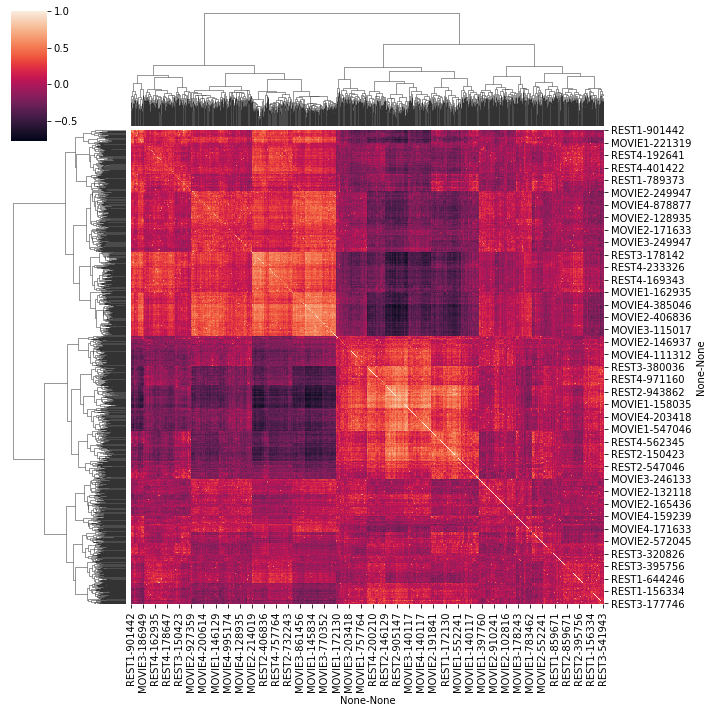

In [20]:
sns.clustermap(sfc.data_pca.T.corr())

***
# Generate Embedding

In [21]:
hover_data = pd.DataFrame({'index':np.arange(N_scans),
                           'run':sfc.label_run,
                           'sbj':sfc.label_sbj,
                           'type': sfc.label_run_type,
                           'gender': sfc.label_gender,
                           'age': sfc.label_age,
                           'psqi': sfc.label_psqi,
                           'fiaa': sfc.label_fiaa,
                           'bmi': sfc.label_bmi,
                           'cogpc1':sfc.label_cogpc1,
                           'mot':sfc.label_rrms_mean})

In [22]:
mapper = UMAP(verbose=True, metric='correlation', min_dist=0.5, init='spectral', n_jobs=24, n_epochs=1000, n_neighbors=50, random_state=43).fit(sfc.data)

UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.5, n_epochs=1000, n_jobs=24, n_neighbors=50, random_state=43, verbose=True)
Tue Jul 19 11:59:57 2022 Construct fuzzy simplicial set
Tue Jul 19 12:01:38 2022 Finding Nearest Neighbors
Tue Jul 19 12:01:40 2022 Finished Nearest Neighbor Search
Tue Jul 19 12:01:42 2022 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Tue Jul 19 12:01:52 2022 Finished embedding


In [23]:
p = umap.plot.interactive(mapper, labels=sfc.label_run_type, hover_data=hover_data, point_size=5, width=500, height=500, theme='fire')
umap.plot.show(p)

***